SEIRS model with seasonality

Many diseases have a seasonal pattern. For example, influenza is more common in the winter, and malaria is more common in the rainy season. In this example, we will show how to incorporate seasonality into the SEIRS model.

First we will create a class SEIRS that describes the model and then we will create a class SEIRS_seasonal that inherits from SEIRS and adds seasonality. Then we will run both models and compare the results.

In [2]:
# Importing everything we need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sirpy.models.abstractModel import AbstractModel, State, Transition
from sirpy.trainers.LeastSquaresTrainer import LeastSquaresTrainer
from typing import Any


In [3]:
# Creating the SEIRS model
class SEIRS(AbstractModel):
    def __init__(self,
                 name: str,
                 hyper_params: dict,
                 train_params: dict,
                 static_params: dict,
                 *args: Any,
                 **kwargs: Any) -> None:
        super().__init__(name, hyper_params, train_params, static_params, *args, **kwargs)
        self.add_states([
            State("S"),
            State("E"),
            State("I"),
            State("R"),
        ])
        self.add_transitions(
            [
            Transition(r"$\beta$SE", "S", "E", lambda t, y, p: p.beta* y.S * y.I), # New Cases
            Transition(r"$\alpha$E","E", "I", lambda t, y, p: p.alpha * y.E), # Incubation
            Transition(r"$\gamma$I","I", "R", lambda t, y, p: p.gamma * y.I), # Recovery
            Transition(r"$\epsilon$R","R", "S", lambda t, y, p: p.eps * y.R), # Loss of immunity
            ]
        )



In [4]:
# time points
t = np.linspace(0, 730, 730)

<AxesSubplot: title={'center': 'SEIRS'}>

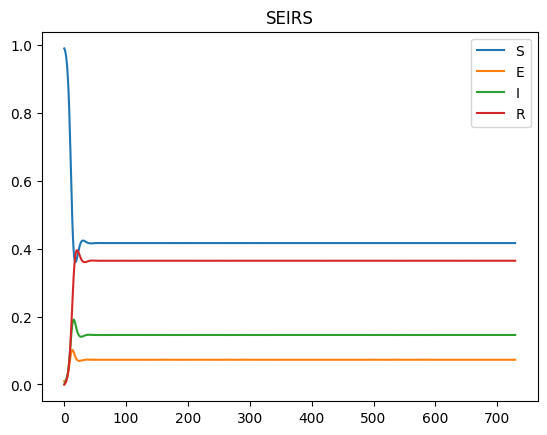

In [5]:
x = SEIRS(
    name="SEIRS",
    hyper_params={
        "time_space": (0, t.max()),
        "time_range": t,
    },
    train_params={
        "beta": 1.2,
        "alpha": 1,
        "gamma": 0.5,
        "eps": 0.2,
    },
    static_params={
         "initial_condition": np.array([0.99, 0.01, 0.0, 0.0])
    })
LeastSquaresTrainer(x).plot_curves()

In [6]:
# Creating the SEIRS model with seasonality

class SEIRS_seasonal(SEIRS):
    def __init__(self,
         name: str,
         hyper_params: dict,
         train_params: dict,
         static_params: dict,
         *args: Any,
         **kwargs: Any) -> None:
        super().__init__(name, hyper_params, train_params, static_params, *args, **kwargs)

        # Changing the first transition so beta depends on t
        self.transitions[0] = Transition(r"$\beta (T)$SE", "S", "E",
                                         lambda t, y, p: p.beta * y.S * y.I * np.sin(2*np.pi*t/p.period))


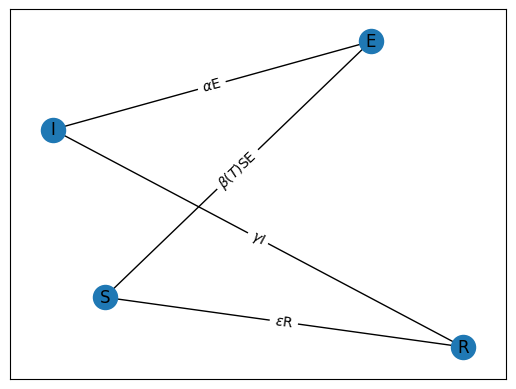

In [7]:
x = SEIRS_seasonal(
    name="seasonal SEIRS",
    hyper_params={
        "time_space": (0, t.max()),
        "time_range": t,
    },
    train_params={
        "beta": 1.2,
        "alpha": 0.9,
        "gamma": 0.5,
        "eps": 0.7,
        "period": 365,
    },
    static_params={
         "initial_condition": np.array([0.99, 0.01, 0.0, 0.0])
    })
x.plot_model()

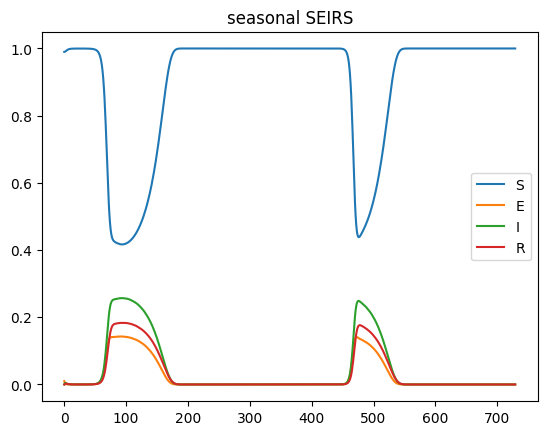

In [8]:
LeastSquaresTrainer(x).plot_curves()
plt.show()

Now that we have created and tested our model clases lets try fitting them to real data.

## Fitting the SEIRS model to real data about the Chickenpox Cases in Hungary

In [9]:
# loading the data
data = pd.read_csv("data/hungary_chickenpox.csv", index_col=0, parse_dates=True, dayfirst=True)
data.head()

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


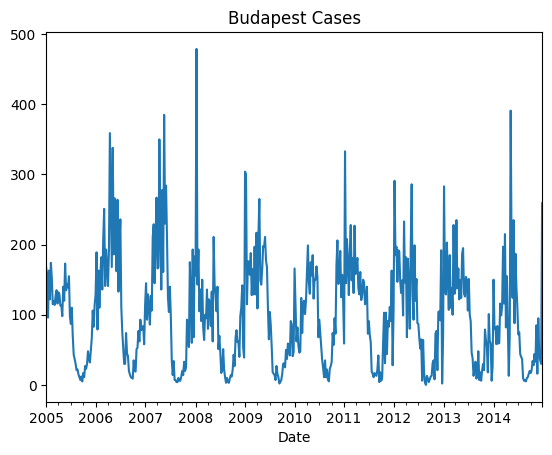

In [10]:
# Lets plot one city history to see the seasonality
data["BUDAPEST"].plot(title="Budapest Cases")
plt.show()

If we look carefully at the data we can see that the number of cases is not constant over time. It is higher in the winter and lower in the summer. This is a seasonal pattern. We can try to fit the SEIRS model to this data and see if we can get a better fit than the SEIRS model without seasonality.

Also note that the cases are reported everyweek so we have to consider a year every 52 weeks.

<AxesSubplot: >

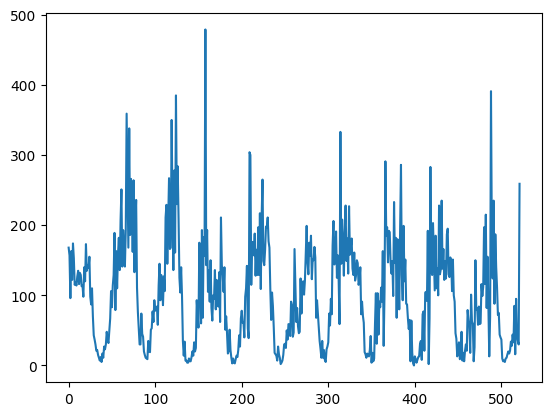

In [11]:
# Lets start by just fitting budapest data

budapest = data["BUDAPEST"]

# Lets reset the index
budapest = budapest.reset_index(drop=True)

budapest.plot()

In [12]:
# The poblation of budapest have been near constant over the years
# The suscetible population is the poblation of children
N = 243977
# Lets normalize the cases multiplied
budapest = budapest/N
budapest

0      0.000689
1      0.000644
2      0.000393
3      0.000668
4      0.000500
         ...   
517    0.000389
518    0.000176
519    0.000143
520    0.000123
521    0.001062
Name: BUDAPEST, Length: 522, dtype: float64

Because we only have the cases data we must define a new residual function that only takes into account the cases data.

In [13]:
def only_cases_residual_fun(x: np.ndarray, trainer: LeastSquaresTrainer):
    trainer.model.set_train_params_from_list(x)
    y_pred = trainer.calculate_curves()
    diff = trainer.model.train_data - y_pred[:, 2]
    return diff.flatten()


<AxesSubplot: title={'center': 'Chickenpox with SEIRS'}>

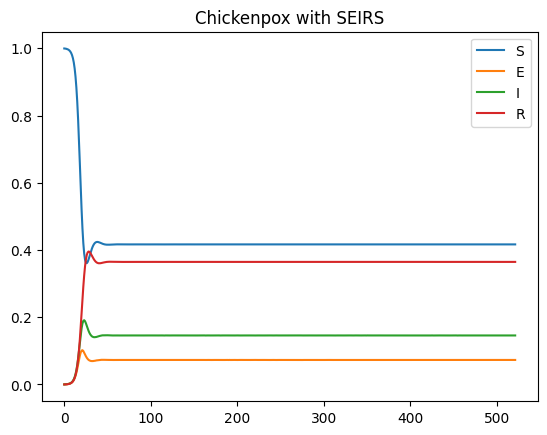

In [14]:
normal_seirs = SEIRS(
    name="Chickenpox with SEIRS",
    hyper_params={
        "time_space": (budapest.index.min(), budapest.index.max()),
        "time_range": budapest.index,
    },
    train_params={
        "beta": 1.2,
        "alpha": 1,
        "gamma": 0.5,
        "eps": 0.2,
    },
    static_params={
         "initial_condition": np.array([0.9994, 0.0006, 0.0, 0.0])
    })
normal_seirs.train_data = budapest.values
normal_trainer= LeastSquaresTrainer(normal_seirs)
normal_trainer.residual_fun = only_cases_residual_fun
normal_trainer.plot_curves()

<AxesSubplot: title={'center': 'ChickenPox with seasonal SEIRS'}>

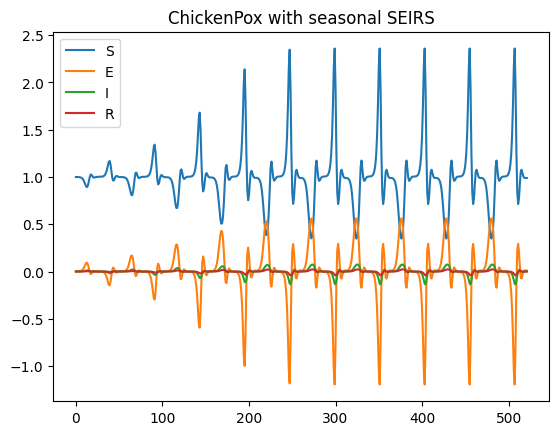

In [57]:
seasonal_seirs = SEIRS_seasonal(
    name="ChickenPox with seasonal SEIRS",
    hyper_params={
        "time_space": (budapest.index.min(), budapest.index.max()),
        "time_range": budapest.index,
    },
    train_params={
        "beta": 9.2,
        "alpha": 0.1,
        "gamma": 0.7,
        "eps": 2.3,
        "period": 52/2
    },
    static_params={
         "initial_condition": np.array([0.999311, 0.000689, 0.0, 0.0])
    })
seasonal_seirs.train_data = budapest.values
seasonal_trainer = LeastSquaresTrainer(seasonal_seirs)
seasonal_trainer.residual_fun = only_cases_residual_fun
seasonal_trainer.plot_curves()

In [ ]:
seasonal_trainer.train()

#TODO: FINISH THIS!